In [3]:
import torch
import torchvision
import tqdm
import os

from transformers import CLIPVisionModelWithProjection, ViTForImageClassification, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer
import numpy as np

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

In [12]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
torch.cuda.is_available()

True

In [13]:
path = '/home/jgryu/Weight_compression/Wparam_dataset/Wparam_npy/llama_7b_self_attn_d=2048_val.npy'
os.path.isfile(path)

True

In [3]:
import numpy as np
gparams = np.load('/home/jgryu/Weight_compression/RD-sandwich/data/gaussian_params-dim=1000.npz')
loc = gparams['loc']
scale = gparams['scale']

In [6]:
d = np.load("/home/jgryu/Weight_compression/Wparam_dataset/Wparam_npy/llama_7b_self_attn_d=2048_train.npy")

In [7]:
d.shape

(2936012, 2048)

In [10]:
wp_mean = 8.708306e-07
wp_std = 0.023440132
nor_d = (d - wp_mean) / wp_std

In [11]:
print(d.max(), d.min())
print(nor_d.max(), nor_d.min())

1.453125 -1.4765625
61.993004 -62.99296


In [7]:
# m = d.mean(axis=0)
# s = d.var(axis=0)
m = d.mean()
s = d.var()

In [11]:
std = d.std()

In [12]:
std

0.023440132

In [14]:
nor_d = (d-m)/std

In [17]:
nor_d.var(axis=0)

array([1.0009615, 1.0072731, 1.1371735, ..., 0.9774631, 0.9887671,
       0.987939 ], dtype=float32)

In [13]:
np.sqrt(s)

0.023440132

In [8]:
m

8.708306e-07

In [27]:
scale_s = s
for i in scale_s:
    print(i)

0.0005519013
0.00055592053
0.0006244048
0.0005502901
0.00054507813
0.000547752
0.00054456946
0.0005488622
0.00055248634
0.0005476372
0.000549594
0.0005429699
0.0005469753
0.0005620375
0.0005419004
0.0005519321
0.00054698763
0.00054371735
0.000549649
0.0005512757
0.0005441512
0.0005516877
0.0006109052
0.0005499016
0.0005367981
0.00054645847
0.00056516216
0.0005391629
0.0005643185
0.000583725
0.00056811195
0.0005474951
0.0005441823
0.00054927083
0.00054851687
0.000545287
0.00054395455
0.00054915145
0.0005391971
0.00054115546
0.0005386838
0.0005464965
0.0005479124
0.0005638776
0.00055515656
0.0005476286
0.0005493475
0.0005439585
0.0005352645
0.0005484602
0.0005593901
0.0005435107
0.00054504856
0.0005528241
0.00054054696
0.0005467469
0.00054280367
0.00055291894
0.0005438386
0.0005444267
0.0005405132
0.0005475916
0.0005508495
0.0005472913
0.00053791975
0.00054547255
0.00055312295
0.0005538455
0.00054435764
0.00054462935
0.00054843625
0.00054445997
0.0005436076
0.0005515073
0.0005502792
0.00

In [1]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

/home/jgryu/miniconda3/envs/effl_project/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
IMAGENET_DEFAULT_STD

(0.229, 0.224, 0.225)

In [4]:
loc.mean()

-0.004078466

In [11]:
loc[0]

0.048813503

In [5]:
loc.mean(), loc.var(), loc.min(), loc.max()

(-0.004078466, 0.08444769, -0.49945402, 0.49980858)

In [ ]:
scale

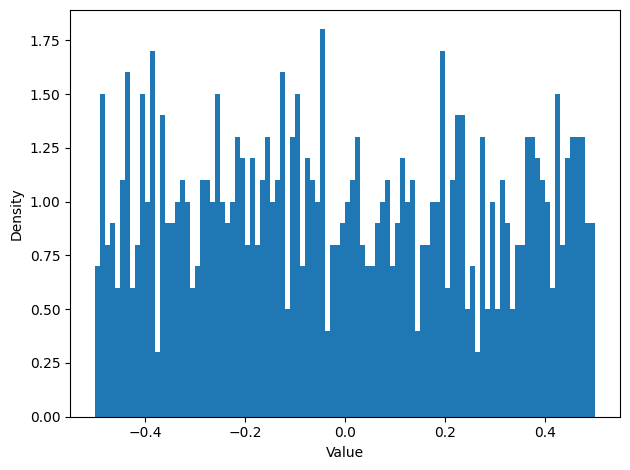

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(1,1, 1)

ax.hist(loc, bins=100, density=True)
# plt.title(p)
plt.xlabel("Value")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

In [8]:
np.median(loc)

-0.018677436

In [2]:
def latest_version_path(cache_dir, model_name, branch = 'main'):
    model_name_dir =  "models--" + model_name.replace('/', '--')
    path = os.path.join(cache_dir, model_name_dir)

    if not os.path.isdir(os.path.join(path, 'snapshots')):
        return None
    
    branch_file =  os.path.join(path, 'refs', branch)

    with open(branch_file, 'r', encoding='utf-8') as file:
        revision = file.read()

    return os.path.join(path, 'snapshots', revision)

In [11]:
cache_path = "/home/jgryu/Weight_compression/model_zoo/huggingface/"
# model_name =  "meta-llama/Llama-2-13b-chat-hf"
model_name =  "google--codegemma-1.1-7b-it"


filepath = latest_version_path(cache_path, model_name)
# print(filepath)
if filepath is not None:
    model = AutoModelForCausalLM.from_pretrained(filepath, local_files_only=True)
    state_dict = model.state_dict()

    for k, v in state_dict.items():
        print(k)
        print(v.shape)

Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


model.embed_tokens.weight
torch.Size([256000, 3072])
model.layers.0.self_attn.q_proj.weight
torch.Size([4096, 3072])
model.layers.0.self_attn.k_proj.weight
torch.Size([4096, 3072])
model.layers.0.self_attn.v_proj.weight
torch.Size([4096, 3072])
model.layers.0.self_attn.o_proj.weight
torch.Size([3072, 4096])
model.layers.0.mlp.gate_proj.weight
torch.Size([24576, 3072])
model.layers.0.mlp.up_proj.weight
torch.Size([24576, 3072])
model.layers.0.mlp.down_proj.weight
torch.Size([3072, 24576])
model.layers.0.input_layernorm.weight
torch.Size([3072])
model.layers.0.post_attention_layernorm.weight
torch.Size([3072])
model.layers.1.self_attn.q_proj.weight
torch.Size([4096, 3072])
model.layers.1.self_attn.k_proj.weight
torch.Size([4096, 3072])
model.layers.1.self_attn.v_proj.weight
torch.Size([4096, 3072])
model.layers.1.self_attn.o_proj.weight
torch.Size([3072, 4096])
model.layers.1.mlp.gate_proj.weight
torch.Size([24576, 3072])
model.layers.1.mlp.up_proj.weight
torch.Size([24576, 3072])
model.

In [12]:
cache_path = "/home/jgryu/Weight_compression/model_zoo/huggingface/"
model_name =  "meta-llama/Llama-2-13b-chat-hf"
# model_name =  "google--codegemma-1.1-7b-it"


filepath = latest_version_path(cache_path, model_name)
# print(filepath)
if filepath is not None:
    model = AutoModelForCausalLM.from_pretrained(filepath, local_files_only=True)
    state_dict = model.state_dict()

    for k, v in state_dict.items():
        print(k)
        print(v.shape)

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.20s/it]


model.embed_tokens.weight
torch.Size([32000, 5120])
model.layers.0.self_attn.q_proj.weight
torch.Size([5120, 5120])
model.layers.0.self_attn.k_proj.weight
torch.Size([5120, 5120])
model.layers.0.self_attn.v_proj.weight
torch.Size([5120, 5120])
model.layers.0.self_attn.o_proj.weight
torch.Size([5120, 5120])
model.layers.0.mlp.gate_proj.weight
torch.Size([13824, 5120])
model.layers.0.mlp.up_proj.weight
torch.Size([13824, 5120])
model.layers.0.mlp.down_proj.weight
torch.Size([5120, 13824])
model.layers.0.input_layernorm.weight
torch.Size([5120])
model.layers.0.post_attention_layernorm.weight
torch.Size([5120])
model.layers.1.self_attn.q_proj.weight
torch.Size([5120, 5120])
model.layers.1.self_attn.k_proj.weight
torch.Size([5120, 5120])
model.layers.1.self_attn.v_proj.weight
torch.Size([5120, 5120])
model.layers.1.self_attn.o_proj.weight
torch.Size([5120, 5120])
model.layers.1.mlp.gate_proj.weight
torch.Size([13824, 5120])
model.layers.1.mlp.up_proj.weight
torch.Size([13824, 5120])
model.l

## TFrecord dataset mean std계산

In [4]:
import tensorflow as tf

# TFRecord 파일 경로
tfrecord_file = '/home/jgryu/Weight_compression/Wparam_dataset/TFRecord/meta-llama/Meta-Llama-3-8B/mlp_d1024_val.tfrecord'

# Feature 파싱 함수 정의
def parse_tfrecord_fn(example_proto):
    # TFRecord에 있는 데이터의 feature 정의 (1024차원 feature)
    feature_description = {
        'slice': tf.io.FixedLenFeature([1024], tf.float32),  # 1024차원 feature로 설정
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    return parsed_example['slice']  # 사용할 feature 선택

# TFRecord 데이터셋 로드
dataset = tf.data.TFRecordDataset(tfrecord_file)
dataset = dataset.map(parse_tfrecord_fn)

# 평균 및 표준 편차 계산 함수
def calculate_mean_and_std(dataset, feature_dim=1024):
    # 평균 계산
    total_sum = tf.zeros([feature_dim], dtype=tf.float32)
    total_count = 0
    for value in dataset:
        total_sum += value
        total_count += 1
    mean_vector = total_sum / total_count if total_count > 0 else tf.zeros([feature_dim], dtype=tf.float32)
    
    # 분산 계산
    variance_sum = tf.zeros([feature_dim], dtype=tf.float32)
    for value in dataset:
        variance_sum += (value - mean_vector) ** 2
    std_vector = tf.sqrt(variance_sum / total_count) if total_count > 0 else tf.zeros([feature_dim], dtype=tf.float32)
    
    return mean_vector, std_vector

# 평균 및 표준 편차 계산
mean_vector, std_vector = calculate_mean_and_std(dataset)
print(f'각 차원별 평균 값: {mean_vector.numpy()}')
print(f'각 차원별 표준 편차: {std_vector.numpy()}')


import numpy as np
path = '/home/jgryu/Weight_compression/Wparam_dataset/TFRecord/meta-llama/Meta-Llama-3-8B/mlp_d1024_val_mean_channel.npy'
np.save(path, mean_vector.numpy())
path = '/home/jgryu/Weight_compression/Wparam_dataset/TFRecord/meta-llama/Meta-Llama-3-8B/mlp_d1024_val_std_channel.npy'
np.save(path, std_vector.numpy())


각 차원별 평균 값: [ 1.0062791e-05  4.0517407e-05 -1.0374568e-04 ...  1.5147983e-06
 -1.7613287e-04  4.0792006e-06]
각 차원별 표준 편차: [0.01182688 0.01179839 0.01185048 ... 0.01183916 0.01147975 0.01184377]


In [11]:
import tensorflow as tf

# TFRecord 파일 경로
tfrecord_file = '/home/jgryu/Weight_compression/Wparam_dataset/TFRecord/meta-llama/Meta-Llama-3-8B/mlp_d1024_val.tfrecord'

# Feature 파싱 함수 정의
def parse_tfrecord_fn(example_proto):
    # TFRecord에 있는 데이터의 feature 정의 (1024차원 feature)
    feature_description = {
        'slice': tf.io.FixedLenFeature([1024], tf.float32),  # 1024차원 feature로 설정
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    return parsed_example['slice']  # 사용할 feature 선택

# TFRecord 데이터셋 로드
dataset = tf.data.TFRecordDataset(tfrecord_file)
dataset = dataset.map(parse_tfrecord_fn)

# 전체 평균 및 표준 편차 계산 함수
def calculate_overall_mean_and_std(dataset):
    total_sum = 0.0
    total_count = 0

    # 모든 샘플의 합과 개수 계산
    for value in dataset:
        total_sum += tf.reduce_sum(value).numpy()  # 전체 feature의 합을 누적
        total_count += value.shape[0]  # 전체 feature의 개수 누적 (1024씩 증가)

    # 전체 평균
    mean_value = total_sum / total_count if total_count > 0 else 0

    # 분산 계산
    variance_sum = 0.0
    for value in dataset:
        variance_sum += tf.reduce_sum((value - mean_value) ** 2).numpy()
    std_value = (variance_sum / total_count) ** 0.5 if total_count > 0 else 0
    
    return mean_value, std_value

# 전체 평균 및 표준 편차 계산
mean_value, std_value = calculate_overall_mean_and_std(dataset)
print(f'전체 데이터 평균 값: {mean_value}')
print(f'전체 데이터 표준 편차: {std_value}')

import numpy as np
path = '/home/jgryu/Weight_compression/Wparam_dataset/TFRecord/meta-llama/Meta-Llama-3-8B/mlp_d1024_val_mean.npy'
np.save(path, mean_vector.numpy())
path = '/home/jgryu/Weight_compression/Wparam_dataset/TFRecord/meta-llama/Meta-Llama-3-8B/mlp_d1024_val_std.npy'
np.save(path, std_vector.numpy())

전체 데이터 평균 값: -5.42295056421355e-06
전체 데이터 표준 편차: 0.011819059083636133


In [12]:
np.set_printoptions(threshold=np.inf)
print(f'각 차원별 평균 값: {mean_vector.numpy()}')
print(f'각 차원별 표준 편차: {std_vector.numpy()}')

각 차원별 평균 값: [ 1.00627913e-05  4.05174069e-05 -1.03745682e-04  4.08225096e-05
  8.00399866e-05 -1.20562154e-05 -2.35987063e-05 -2.57367574e-05
  7.61593474e-05  5.54684520e-05 -1.53281144e-05  7.49116516e-05
 -2.25087315e-05 -3.83869847e-05 -1.02051898e-04 -4.26129351e-04
 -8.75328333e-05 -2.69055145e-05  1.21108875e-04 -6.66051201e-05
  8.03597686e-06 -3.19661667e-05  1.24425942e-05 -1.93563164e-06
 -1.08507244e-04 -4.64593722e-05 -6.73827817e-05 -1.02629510e-05
  1.95690245e-05 -3.20448089e-05 -8.45169052e-05  1.02131962e-05
  3.89791021e-05 -4.59037219e-05 -3.86079773e-04 -3.76285170e-04
  1.41589517e-05  5.69974873e-05 -6.35780380e-05 -9.97388634e-05
  5.63533213e-05 -1.15002549e-04 -1.10231158e-04  1.29960347e-06
  5.04176132e-05 -3.25167406e-07  7.75887474e-06  1.55667640e-05
  1.11139678e-04 -4.07637235e-05  2.59978915e-05  7.74624641e-05
 -6.37498888e-05  7.44852805e-05 -1.34185420e-05 -7.11185976e-06
 -4.63900033e-05 -2.24426876e-05  6.21258596e-06  1.61783115e-04
 -8.30200224e

: 